In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

synthetic_df = pd.read_csv('synthetic_data.csv')
original_df = pd.read_csv('WEB_TARGET.csv')

### Multiclass Classification of 6 month occlusion '6_mo_occ'

In [3]:
original_df.columns

Index(['Age', 'Sex', 'Ruptured', 'Circulation', 'Location', 'Ignore',
       'Max diameter in any dimension (mm)', 'Height (mm)', 'Width (mm)',
       'Other diameter', 'Neck (mm) orthogonal view 1',
       'Neck (mm) orthogonal view 2', 'Avg neck vol', 'Aneurysm 3D Volume',
       'WEB_1_Name', 'SL/Elongated', 'WEB_1_width', 'WEB_1_Height',
       'WEB Volume', 'WEB Device #2 name', 'WEB 2 Volume', 'Final WEB Volume',
       'Comments on why a second device needed',
       'Complete WEB failure/abandonment', 'Re-sizing required',
       'Stenting used to support WEB?', 'Composite outcome',
       'Procedure related ischemic stroke?', 'Intraop rupture', '3_mo_occ',
       '6_mo_occ', '1_year_occ', 'Dual_length'],
      dtype='object')

In [3]:
synthetic_df.shape

(1000, 20)

In [4]:
synthetic_df.dtypes

Age                                   float64
Sex                                     int64
Ruptured                                int64
Circulation                             int64
Max diameter in any dimension (mm)    float64
Height (mm)                           float64
Width (mm)                            float64
Neck (mm) orthogonal view 1           float64
Neck (mm) orthogonal view 2           float64
Avg neck vol                          float64
Aneurysm 3D Volume                    float64
SL/Elongated                            int64
Final WEB Volume                      float64
Complete WEB failure/abandonment        int64
Re-sizing required                      int64
Stenting used to support WEB?           int64
Composite outcome                       int64
Procedure related ischemic stroke?      int64
Intraop rupture                         int64
6_mo_occ                                int64
dtype: object

#### Multiclass Classification - Cross-Validation Training and Testing ONLY

C:\Users\shrin\AppData\Local\Temp\ipykernel_13216\3808992614.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


Evaluating Random Forest with Cross-Validation...


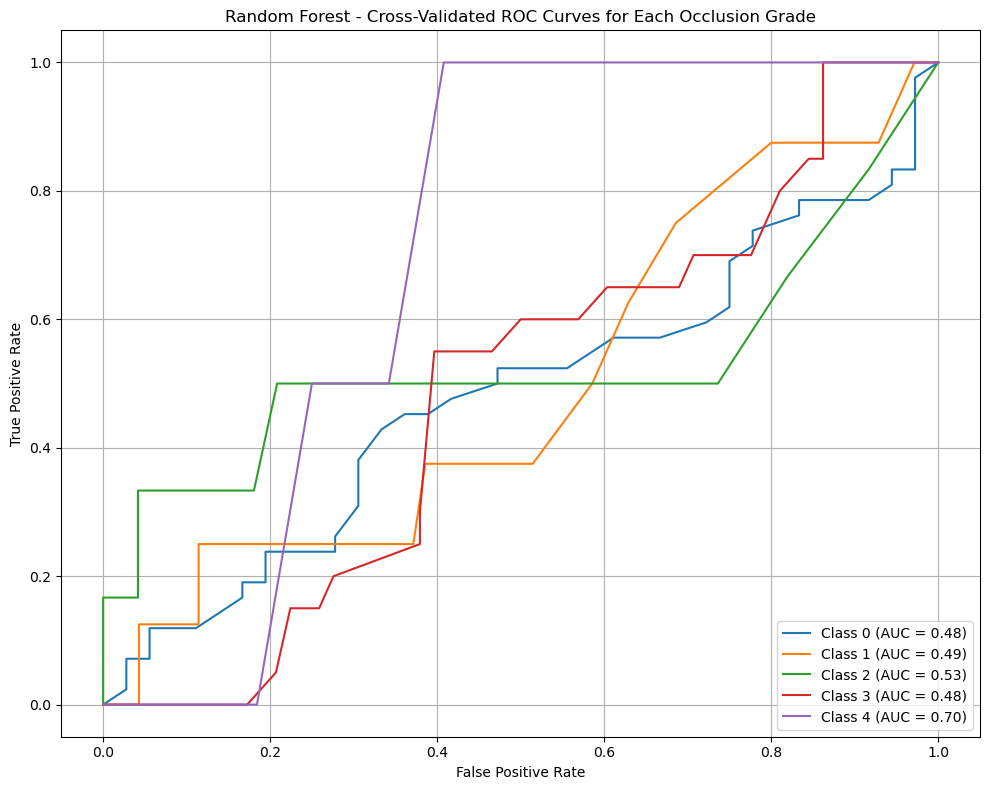


Random Forest Cross-Validation Results:
  Overall AUC: 0.5381
  AUC for Grade 0: 0.4805
  AUC for Grade 1: 0.4946
  AUC for Grade 2: 0.5266
  AUC for Grade 3: 0.4849
  AUC for Grade 4: 0.7039

Classification Report:
              precision    recall  f1-score   support

     Grade 0       0.50      0.81      0.62        42
     Grade 1       0.00      0.00      0.00         8
     Grade 2       0.50      0.17      0.25         6
     Grade 3       0.00      0.00      0.00        20
     Grade 4       0.00      0.00      0.00         2

    accuracy                           0.45        78
   macro avg       0.20      0.20      0.17        78
weighted avg       0.31      0.45      0.35        78

Evaluating XGBoost with Cross-Validation...


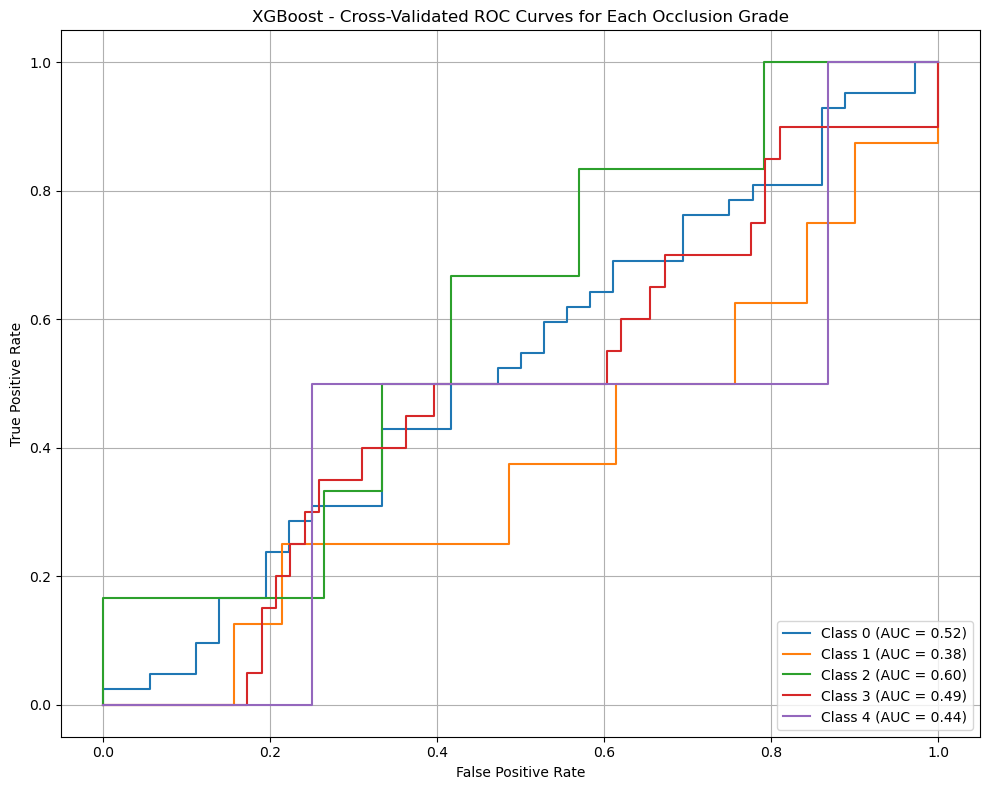


XGBoost Cross-Validation Results:
  Overall AUC: 0.4866
  AUC for Grade 0: 0.5231
  AUC for Grade 1: 0.3786
  AUC for Grade 2: 0.6042
  AUC for Grade 3: 0.4862
  AUC for Grade 4: 0.4408

Classification Report:
              precision    recall  f1-score   support

     Grade 0       0.54      0.88      0.67        42
     Grade 1       0.00      0.00      0.00         8
     Grade 2       0.50      0.17      0.25         6
     Grade 3       0.00      0.00      0.00        20
     Grade 4       0.00      0.00      0.00         2

    accuracy                           0.49        78
   macro avg       0.21      0.21      0.18        78
weighted avg       0.33      0.49      0.38        78



In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
import matplotlib.pyplot as plt


# Define features and target
features = [
    'Age', 'Sex', 'Ruptured', 'Circulation',
    'Max diameter in any dimension (mm)', 'Height (mm)', 'Width (mm)',
    'Neck (mm) orthogonal view 1', 'Neck (mm) orthogonal view 2',
    'Avg neck vol', 'Aneurysm 3D Volume', 'SL/Elongated', 'Final WEB Volume',
    'Complete WEB failure/abandonment', 'Re-sizing required',
    'Stenting used to support WEB?', 'Composite outcome',
    'Procedure related ischemic stroke?', 'Intraop rupture'
]
target = '6_mo_occ'

# Prepare data for cross-validation
X = original_df[features]
y = original_df[target]

X.fillna(X.mean(), inplace=True)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=10,
    scoring='roc_auc_ovr',
    n_jobs=-1
)
grid_search_rf.fit(X, y)
best_rf_original = grid_search_rf.best_estimator_

grid_search_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid_xgb,
    cv=10,
    scoring='roc_auc_ovr',
    n_jobs=-1
)
grid_search_xgb.fit(X, y)
best_xgb_original = grid_search_xgb.best_estimator_

models_original = {
    'Random Forest': best_rf_original,
    'XGBoost': best_xgb_original
}

results = {}
for model_name, model in models_original.items():
    print(f"Evaluating {model_name} with Cross-Validation...")

    y_proba = cross_val_predict(model, X, y, cv=5, method='predict_proba')
    
    class_aucs = {}
    plt.figure(figsize=(10, 8))
    for class_label in np.unique(y):
        y_binary = (y == class_label).astype(int)
        
        fpr, tpr, _ = roc_curve(y_binary, y_proba[:, class_label])
        roc_auc = auc(fpr, tpr)
        class_aucs[class_label] = roc_auc
        
        plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")
    
    overall_auc = roc_auc_score(y, y_proba, multi_class='ovr')
    results[model_name] = {
        'Overall AUC': overall_auc,
        'Class AUCs': class_aucs
    }

    plt.title(f"{model_name} - Cross-Validated ROC Curves for Each Occlusion Grade")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    print(f"\n{model_name} Cross-Validation Results:")
    print(f"  Overall AUC: {overall_auc:.4f}")
    for class_label, auc_value in class_aucs.items():
        print(f"  AUC for Grade {class_label}: {auc_value:.4f}")

    y_pred = np.argmax(y_proba, axis=1)
    print("\nClassification Report:")
    print(classification_report(y, y_pred, target_names=[f"Grade {label}" for label in np.unique(y)]))


#### Multiclass classification - Cross-Validation with Random OverSampling

C:\Users\shrin\AppData\Local\Temp\ipykernel_13216\827294549.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


Evaluating Random Forest with Cross-Validation...


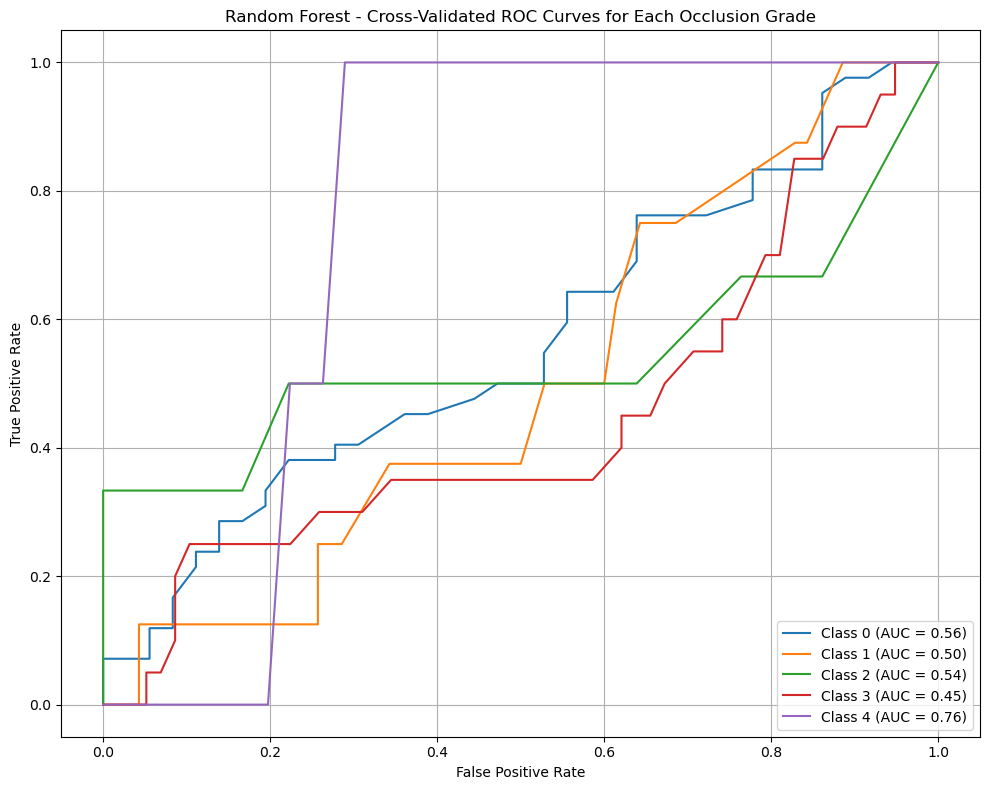


Random Forest Cross-Validation Results:
  Overall AUC: 0.5623
  AUC for Grade 0: 0.5642
  AUC for Grade 1: 0.5018
  AUC for Grade 2: 0.5405
  AUC for Grade 3: 0.4483
  AUC for Grade 4: 0.7566

Classification Report:
              precision    recall  f1-score   support

     Grade 0       0.57      0.62      0.59        42
     Grade 1       0.33      0.12      0.18         8
     Grade 2       0.25      0.33      0.29         6
     Grade 3       0.25      0.25      0.25        20
     Grade 4       0.00      0.00      0.00         2

    accuracy                           0.44        78
   macro avg       0.28      0.27      0.26        78
weighted avg       0.42      0.44      0.42        78

Evaluating XGBoost with Cross-Validation...


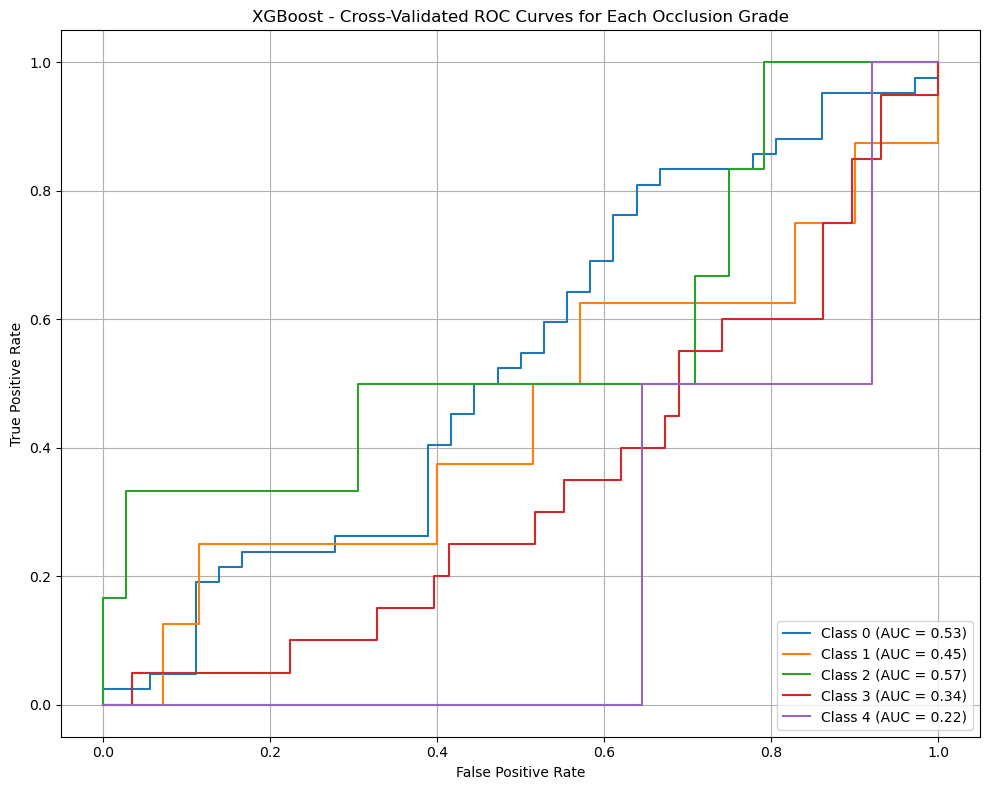


XGBoost Cross-Validation Results:
  Overall AUC: 0.4228
  AUC for Grade 0: 0.5337
  AUC for Grade 1: 0.4500
  AUC for Grade 2: 0.5694
  AUC for Grade 3: 0.3440
  AUC for Grade 4: 0.2171

Classification Report:
              precision    recall  f1-score   support

     Grade 0       0.54      0.45      0.49        42
     Grade 1       0.13      0.25      0.17         8
     Grade 2       0.29      0.33      0.31         6
     Grade 3       0.05      0.05      0.05        20
     Grade 4       0.00      0.00      0.00         2

    accuracy                           0.31        78
   macro avg       0.20      0.22      0.21        78
weighted avg       0.34      0.31      0.32        78



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt

# Define features and target
features = [
    'Age', 'Sex', 'Ruptured', 'Circulation',
    'Max diameter in any dimension (mm)', 'Height (mm)', 'Width (mm)',
    'Neck (mm) orthogonal view 1', 'Neck (mm) orthogonal view 2',
    'Avg neck vol', 'Aneurysm 3D Volume', 'SL/Elongated', 'Final WEB Volume',
    'Complete WEB failure/abandonment', 'Re-sizing required',
    'Stenting used to support WEB?', 'Composite outcome',
    'Procedure related ischemic stroke?', 'Intraop rupture'
]
target = '6_mo_occ'

# Prepare data
X = original_df[features]
y = original_df[target]

# Fill missing values
X.fillna(X.mean(), inplace=True)

# Define parameter grids for GridSearchCV
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0]
}

# Define pipelines with RandomOversampler
pipeline_rf = ImbPipeline([
    ('oversample', RandomOverSampler(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_xgb = ImbPipeline([
    ('oversample', RandomOverSampler(random_state=42)),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Perform grid search for Random Forest
grid_search_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='roc_auc_ovr',
    n_jobs=-1
)
grid_search_rf.fit(X, y)
best_rf = grid_search_rf.best_estimator_

# Perform grid search for XGBoost
grid_search_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid_xgb,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='roc_auc_ovr',
    n_jobs=-1
)
grid_search_xgb.fit(X, y)
best_xgb = grid_search_xgb.best_estimator_

# Models to evaluate
models_original_OS = {
    'Random Forest': best_rf,
    'XGBoost': best_xgb
}

# Cross-validation and evaluation
results = {}
for model_name, model in models_original_OS.items():
    print(f"Evaluating {model_name} with Cross-Validation...")

    y_proba = cross_val_predict(model, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), method='predict_proba')

    class_aucs = {}
    plt.figure(figsize=(10, 8))
    for class_label in np.unique(y):
        y_binary = (y == class_label).astype(int)

        fpr, tpr, _ = roc_curve(y_binary, y_proba[:, class_label])
        roc_auc = auc(fpr, tpr)
        class_aucs[class_label] = roc_auc

        plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")

    overall_auc = roc_auc_score(y, y_proba, multi_class='ovr')
    results[model_name] = {
        'Overall AUC': overall_auc,
        'Class AUCs': class_aucs
    }

    plt.title(f"{model_name} - Cross-Validated ROC Curves for Each Occlusion Grade")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Print metrics
    print(f"\n{model_name} Cross-Validation Results:")
    print(f"  Overall AUC: {overall_auc:.4f}")
    for class_label, auc_value in class_aucs.items():
        print(f"  AUC for Grade {class_label}: {auc_value:.4f}")

    # Classification report (use most likely class predictions)
    y_pred = np.argmax(y_proba, axis=1)
    print("\nClassification Report:")
    print(classification_report(y, y_pred, target_names=[f"Grade {label}" for label in np.unique(y)]))


#### Multiclass classification - CGAN trained, tested on original

C:\Users\shrin\AppData\Local\Temp\ipykernel_33992\117545797.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.fillna(X_test.mean(), inplace=True)


Training Random Forest...


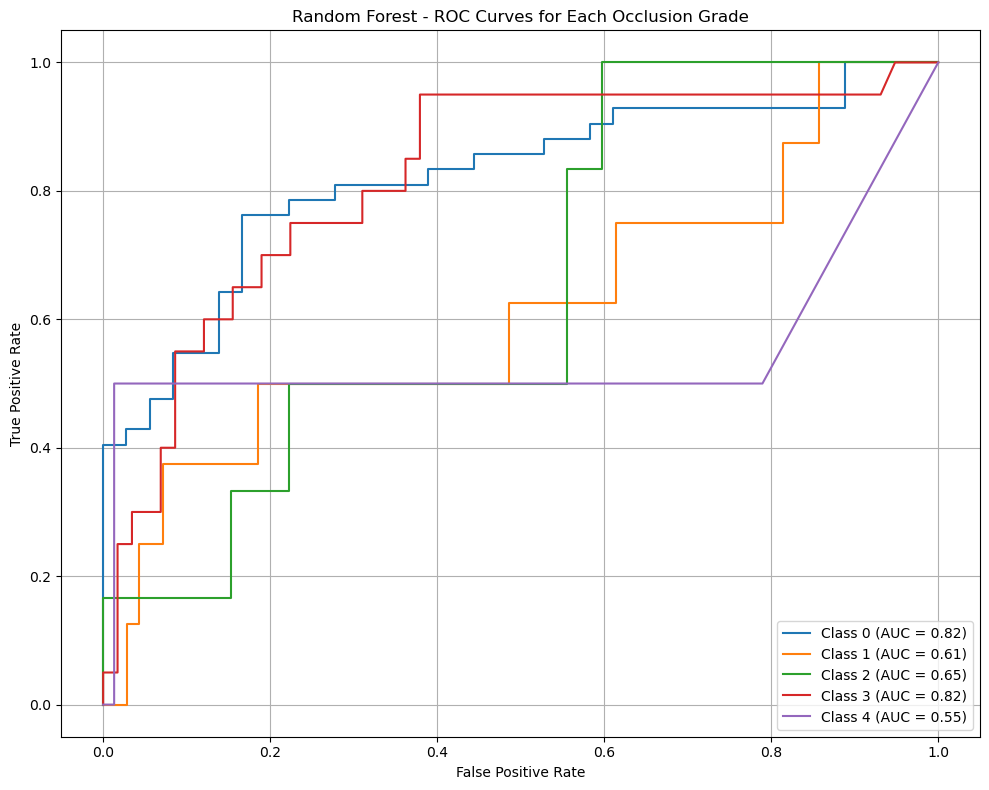


Random Forest Test Metrics on Original Data:
  AUC (Overall): 0.6909
  AUC for Grade 0: 0.8214
  AUC for Grade 1: 0.6125
  AUC for Grade 2: 0.6528
  AUC for Grade 3: 0.8220
  AUC for Grade 4: 0.5461

Classification Report:
              precision    recall  f1-score   support

     Grade 0       0.76      0.81      0.78        42
     Grade 1       0.25      0.25      0.25         8
     Grade 2       0.20      0.17      0.18         6
     Grade 3       0.59      0.50      0.54        20
     Grade 4       0.33      0.50      0.40         2

    accuracy                           0.62        78
   macro avg       0.43      0.45      0.43        78
weighted avg       0.61      0.62      0.61        78

Training XGBoost...


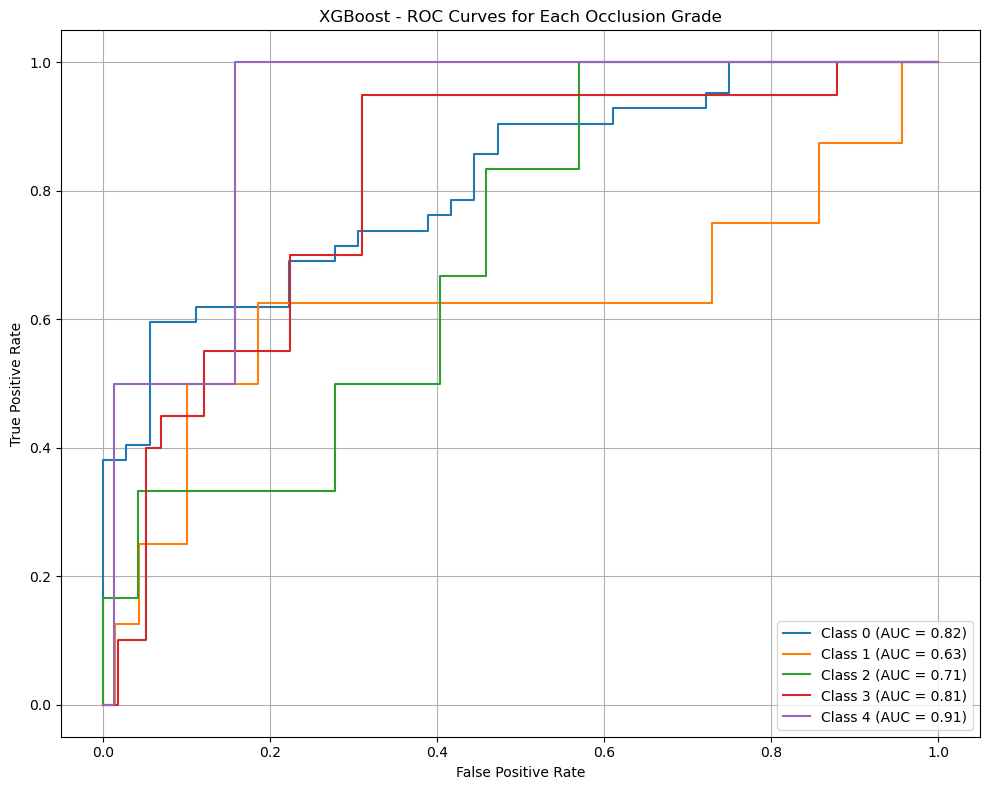


XGBoost Test Metrics on Original Data:
  AUC (Overall): 0.7754
  AUC for Grade 0: 0.8155
  AUC for Grade 1: 0.6268
  AUC for Grade 2: 0.7083
  AUC for Grade 3: 0.8121
  AUC for Grade 4: 0.9145

Classification Report:
              precision    recall  f1-score   support

     Grade 0       0.77      0.64      0.70        42
     Grade 1       0.27      0.38      0.32         8
     Grade 2       0.29      0.33      0.31         6
     Grade 3       0.50      0.55      0.52        20
     Grade 4       0.33      0.50      0.40         2

    accuracy                           0.56        78
   macro avg       0.43      0.48      0.45        78
weighted avg       0.60      0.56      0.58        78



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

# Define features and target
features = [
    'Age', 'Sex', 'Ruptured', 'Circulation',
    'Max diameter in any dimension (mm)', 'Height (mm)', 'Width (mm)',
    'Neck (mm) orthogonal view 1', 'Neck (mm) orthogonal view 2',
    'Avg neck vol', 'Aneurysm 3D Volume', 'SL/Elongated', 'Final WEB Volume',
    'Complete WEB failure/abandonment', 'Re-sizing required',
    'Stenting used to support WEB?', 'Composite outcome',
    'Procedure related ischemic stroke?', 'Intraop rupture'
]
target = '6_mo_occ'

X = synthetic_df[features]
y = synthetic_df[target]

X_test = original_df[features]
y_test = original_df[target]

X_test.fillna(X_test.mean(), inplace=True)

# Define parameter grids for GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Perform grid search for Random Forest
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42), 
    param_grid_rf, 
    cv=5, 
    scoring='roc_auc_ovr', 
    n_jobs=-1
)
grid_search_rf.fit(X, y)
best_rf = grid_search_rf.best_estimator_

# Perform grid search for XGBoost
grid_search_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), 
    param_grid_xgb, 
    cv=5, 
    scoring='roc_auc_ovr', 
    n_jobs=-1
)
grid_search_xgb.fit(X, y)
best_xgb = grid_search_xgb.best_estimator_

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Train models with best hyperparameters
models_CGAN = {
    'Random Forest': best_rf,
    'XGBoost': best_xgb
}

results = {}
for model_name, model in models_CGAN.items():
    print(f"Training {model_name}...")
    model.fit(X, y) 
    
    y_test_proba = model.predict_proba(X_test)
    
    class_aucs = {}
    plt.figure(figsize=(10, 8))
    for class_label in np.unique(y_test):
        y_test_binary = (y_test == class_label).astype(int)
        
        fpr, tpr, _ = roc_curve(y_test_binary, y_test_proba[:, class_label])
        roc_auc = auc(fpr, tpr)
        class_aucs[class_label] = roc_auc
        
        plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")
    
    test_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
    results[model_name] = {
        'Test AUC': test_auc,
        'Class AUCs': class_aucs
    }
    
    plt.title(f"{model_name} - ROC Curves for Each Occlusion Grade")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    print(f"\n{model_name} Test Metrics on Original Data:")
    print(f"  AUC (Overall): {test_auc:.4f}")
    for class_label, auc_value in class_aucs.items():
        print(f"  AUC for Grade {class_label}: {auc_value:.4f}")
    
    y_test_pred = model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred, target_names=[f"Grade {label}" for label in np.unique(y_test)]))


#### Multiclass classification - CGAN trained, Random Oversampling on original data

C:\Users\shrin\AppData\Local\Temp\ipykernel_18732\2692863050.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.fillna(X_test.mean(), inplace=True)


Training Random Forest...


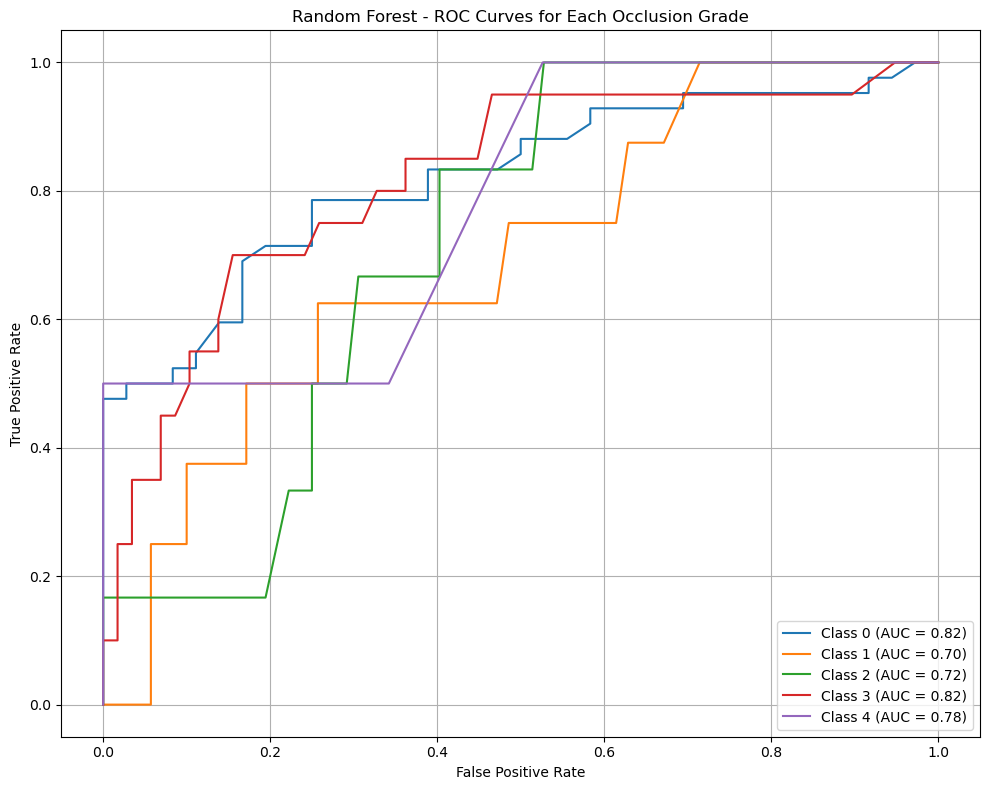


Random Forest Test Metrics on Original Data:
  AUC (Overall): 0.7671
  AUC for Grade 0: 0.8201
  AUC for Grade 1: 0.6955
  AUC for Grade 2: 0.7199
  AUC for Grade 3: 0.8172
  AUC for Grade 4: 0.7829

Classification Report:
              precision    recall  f1-score   support

     Grade 0       0.76      0.69      0.72        42
     Grade 1       0.18      0.25      0.21         8
     Grade 2       0.17      0.17      0.17         6
     Grade 3       0.65      0.55      0.59        20
     Grade 4       0.17      0.50      0.25         2

    accuracy                           0.56        78
   macro avg       0.39      0.43      0.39        78
weighted avg       0.61      0.56      0.58        78

Training XGBoost...


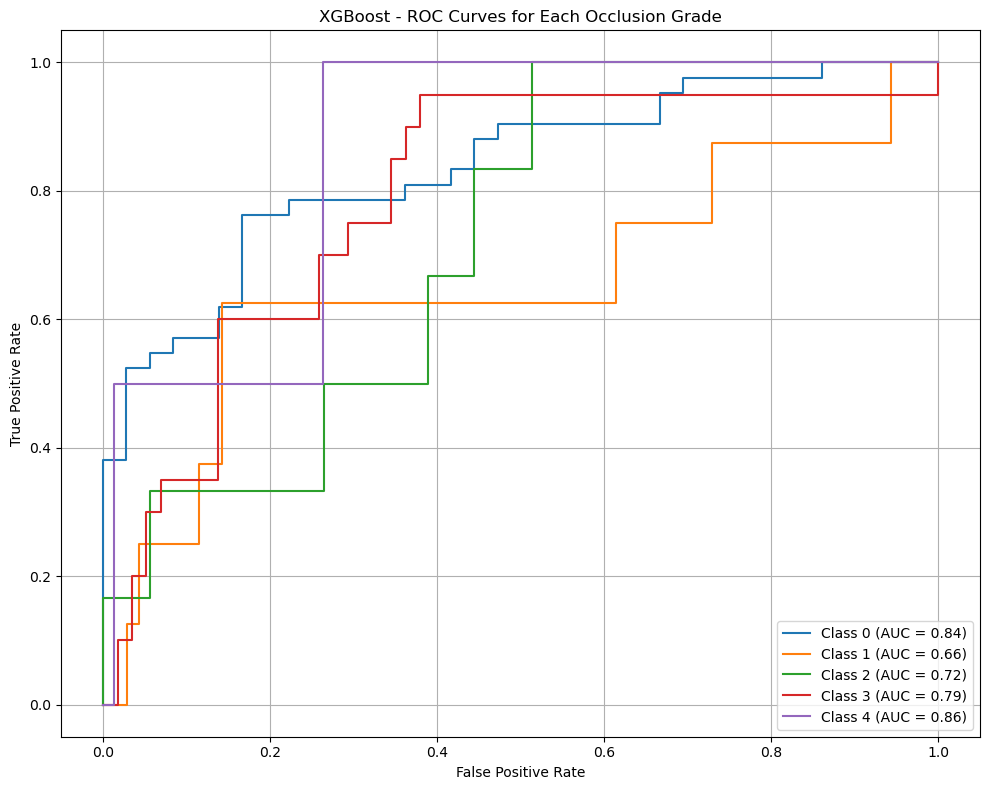


XGBoost Test Metrics on Original Data:
  AUC (Overall): 0.7733
  AUC for Grade 0: 0.8373
  AUC for Grade 1: 0.6554
  AUC for Grade 2: 0.7222
  AUC for Grade 3: 0.7897
  AUC for Grade 4: 0.8618

Classification Report:
              precision    recall  f1-score   support

     Grade 0       0.84      0.64      0.73        42
     Grade 1       0.30      0.38      0.33         8
     Grade 2       0.20      0.33      0.25         6
     Grade 3       0.55      0.60      0.57        20
     Grade 4       0.25      0.50      0.33         2

    accuracy                           0.58        78
   macro avg       0.43      0.49      0.44        78
weighted avg       0.65      0.58      0.60        78



In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

features = [
    'Age', 'Sex', 'Ruptured', 'Circulation',
    'Max diameter in any dimension (mm)', 'Height (mm)', 'Width (mm)',
    'Neck (mm) orthogonal view 1', 'Neck (mm) orthogonal view 2',
    'Avg neck vol', 'Aneurysm 3D Volume', 'SL/Elongated', 'Final WEB Volume',
    'Complete WEB failure/abandonment', 'Re-sizing required',
    'Stenting used to support WEB?', 'Composite outcome',
    'Procedure related ischemic stroke?', 'Intraop rupture'
]
target = '6_mo_occ'

X = synthetic_df[features]
y = synthetic_df[target]

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

X_test = original_df[features]
y_test = original_df[target]

X_test.fillna(X_test.mean(), inplace=True)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='roc_auc_ovr',
    n_jobs=-1
)
grid_search_rf.fit(X_resampled, y_resampled)
best_rf = grid_search_rf.best_estimator_

grid_search_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid_xgb,
    cv=5,
    scoring='roc_auc_ovr',
    n_jobs=-1
)
grid_search_xgb.fit(X_resampled, y_resampled)
best_xgb = grid_search_xgb.best_estimator_

models_CGAN_OS = {
    'Random Forest': best_rf,
    'XGBoost': best_xgb
}

results = {}
for model_name, model in models_CGAN_OS.items():
    print(f"Training {model_name}...")
    model.fit(X_resampled, y_resampled)  
    
    y_test_proba = model.predict_proba(X_test)
    
    class_aucs = {}
    plt.figure(figsize=(10, 8))
    for class_label in np.unique(y_test):
        y_test_binary = (y_test == class_label).astype(int)
        
        fpr, tpr, _ = roc_curve(y_test_binary, y_test_proba[:, class_label])
        roc_auc = auc(fpr, tpr)
        class_aucs[class_label] = roc_auc
        
        plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")
    
    test_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
    results[model_name] = {
        'Test AUC': test_auc,
        'Class AUCs': class_aucs
    }
    
    plt.title(f"{model_name} - ROC Curves for Each Occlusion Grade")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    print(f"\n{model_name} Test Metrics on Original Data:")
    print(f"  AUC (Overall): {test_auc:.4f}")
    for class_label, auc_value in class_aucs.items():
        print(f"  AUC for Grade {class_label}: {auc_value:.4f}")
    
    y_test_pred = model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred, target_names=[f"Grade {label}" for label in np.unique(y_test)]))


#### Model Analysis

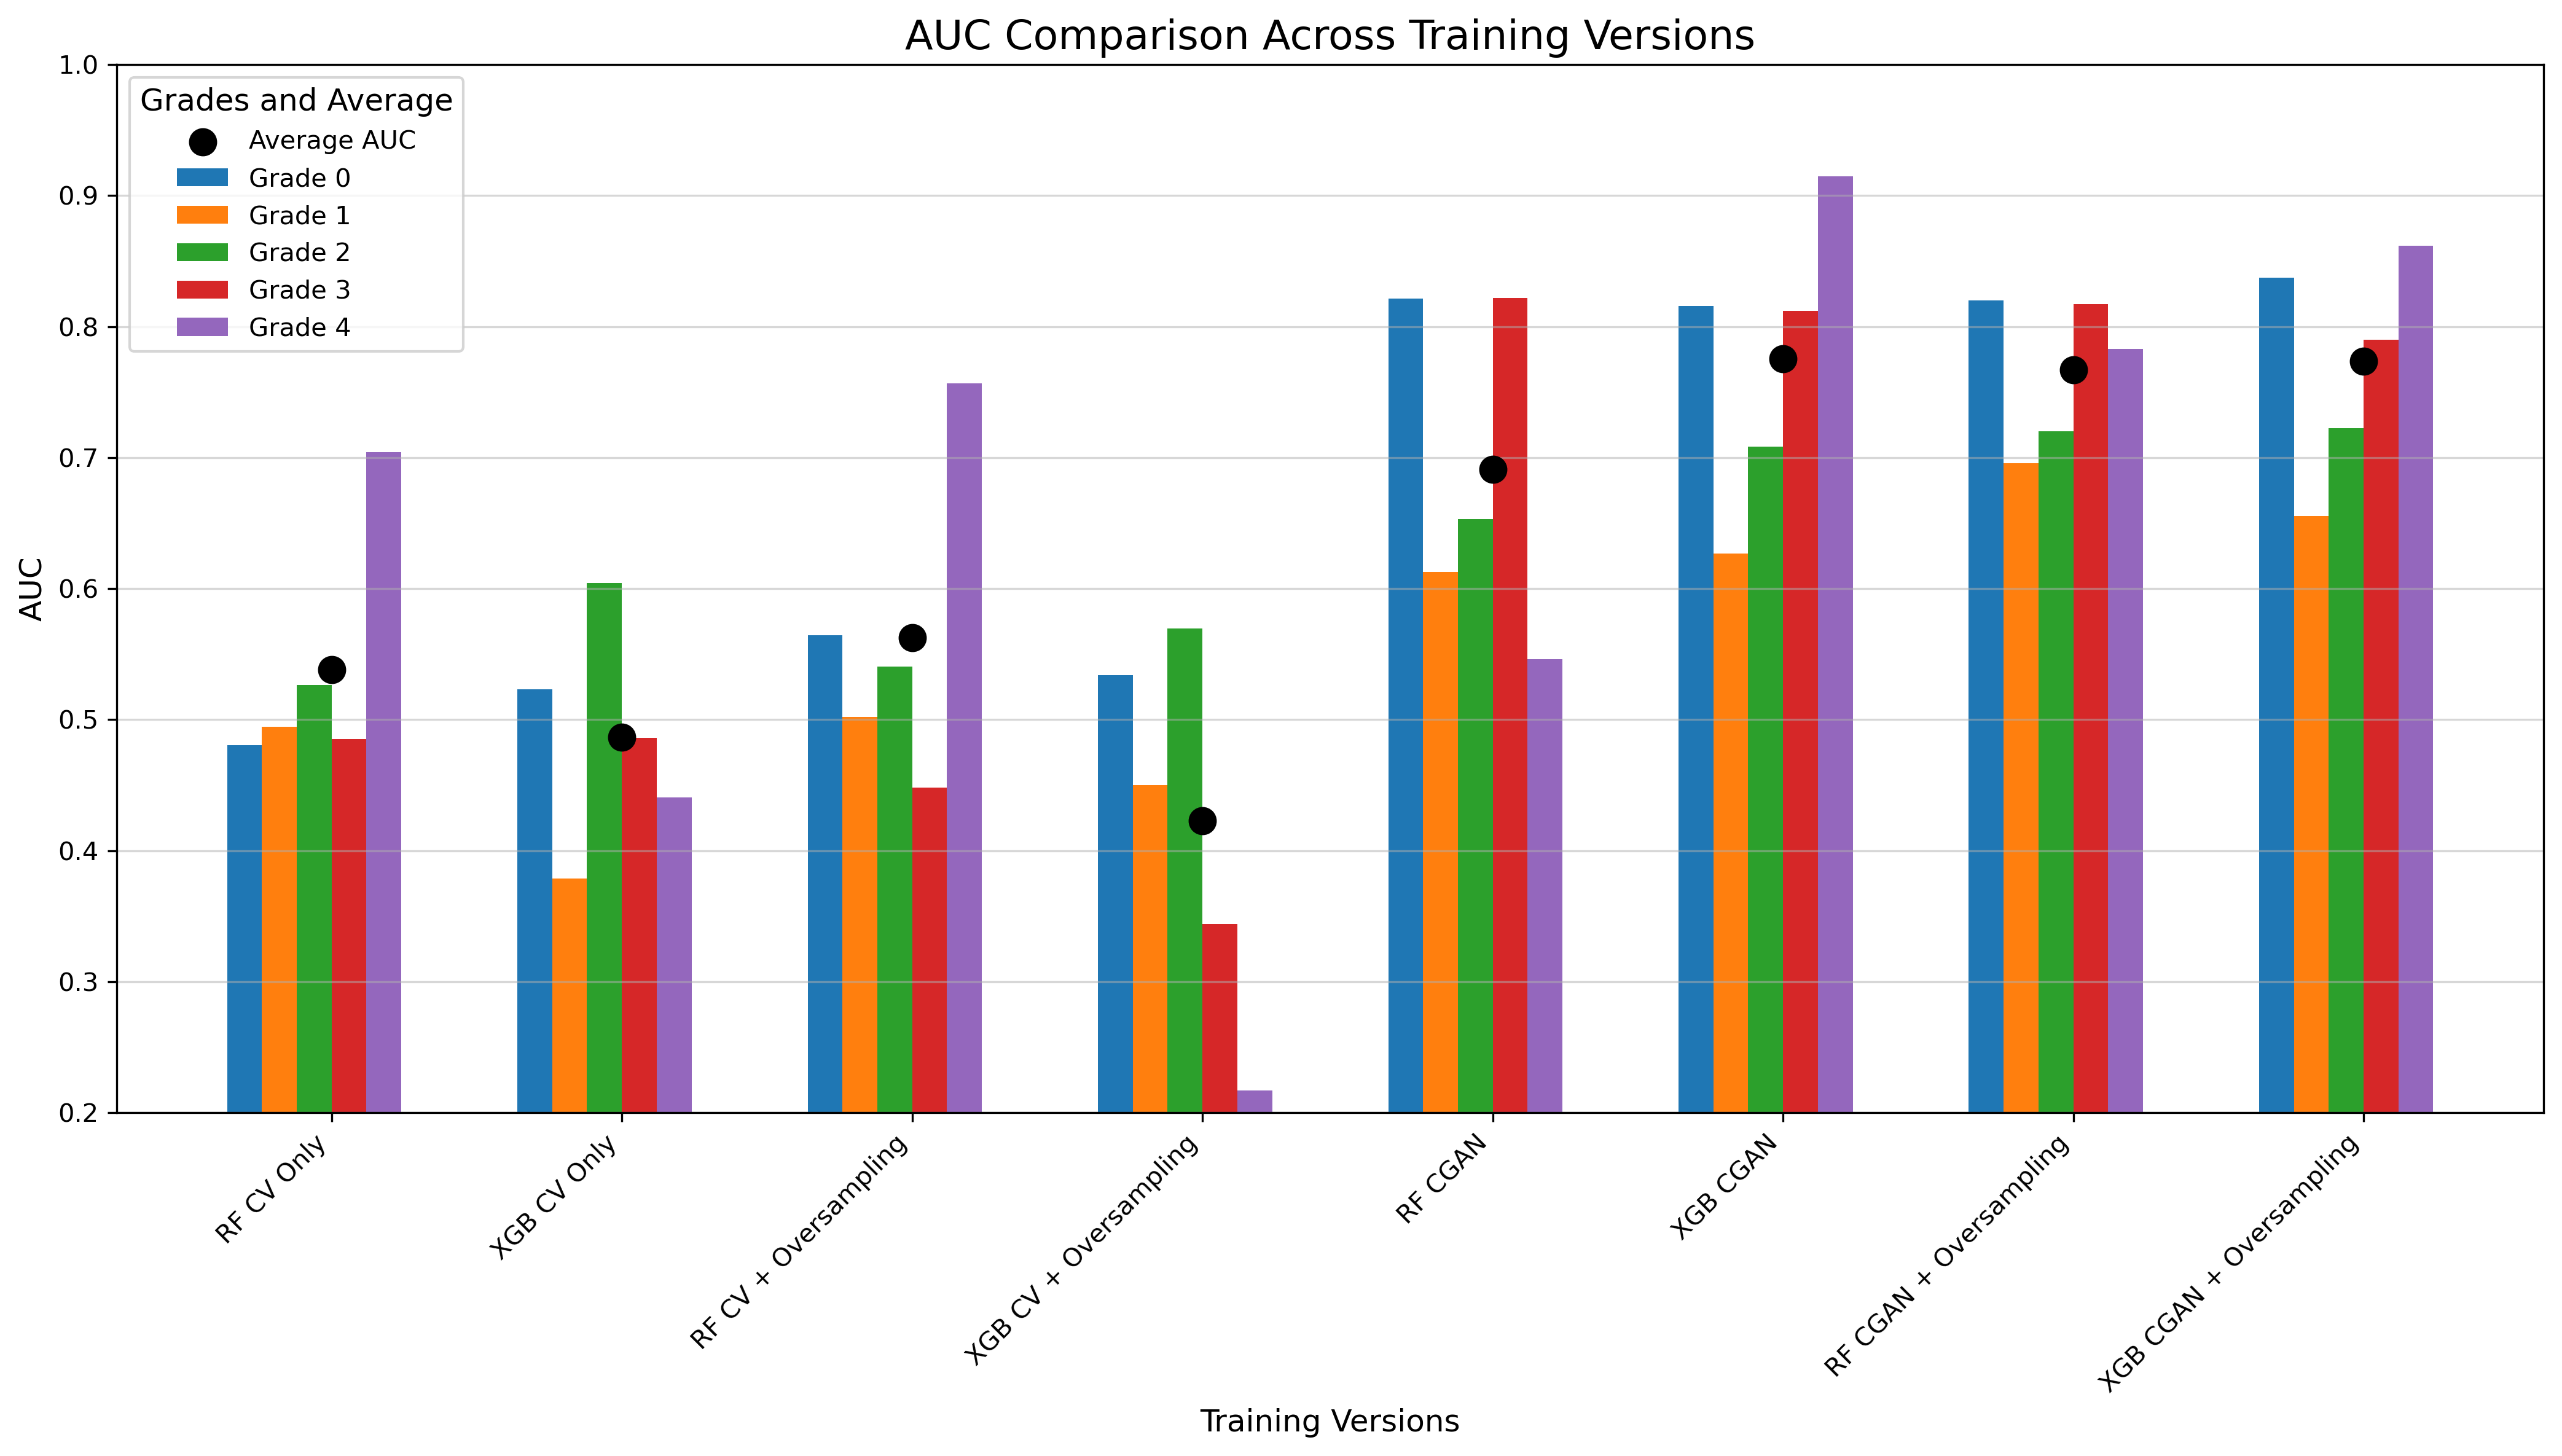

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the chart
training_versions = [
    "RF CV Only",
    "XGB CV Only",
    "RF CV + Oversampling",
    "XGB CV + Oversampling",
    "RF CGAN",
    "XGB CGAN",
    "RF CGAN + Oversampling",
    "XGB CGAN + Oversampling"
]

grades = ["Grade 0", "Grade 1", "Grade 2", "Grade 3", "Grade 4"]
auc_values = [
    [0.4805, 0.4946, 0.5266, 0.4849, 0.7039],  # RF CV Only
    [0.5231, 0.3786, 0.6042, 0.4862, 0.4408],  # XGB CV Only
    [0.5642, 0.5018, 0.5405, 0.4483, 0.7566],  # RF CV + Oversampling
    [0.5337, 0.4500, 0.5694, 0.3440, 0.2171],  # XGB CV + Oversampling
    [0.8214, 0.6125, 0.6528, 0.8220, 0.5461],  # RF CGAN
    [0.8155, 0.6268, 0.7083, 0.8121, 0.9145],  # XGB CGAN
    [0.8201, 0.6955, 0.7199, 0.8172, 0.7829],  # RF CGAN + Oversampling
    [0.8373, 0.6554, 0.7222, 0.7897, 0.8618]   # XGB CGAN + Oversampling
]

average_auc = [ 
    0.5381, 0.4866, 0.5623, 0.4228, 0.6909, 0.7754, 0.7671, 0.7733
]

x = np.arange(len(training_versions)) 
width = 0.12  
n_grades = len(grades)

fig, ax = plt.subplots(figsize=(14, 8), dpi=300)

for i, grade in enumerate(grades):
    ax.bar(
        x + (i - n_grades / 2) * width,
        [auc[i] for auc in auc_values],
        width,
        label=grade
    )

ax.scatter(
    x,
    average_auc,
    color='black',
    zorder=5,
    label="Average AUC",
    marker='o',
    s=100
)

ax.set_xlabel("Training Versions", fontsize=12)
ax.set_ylabel("AUC", fontsize=12)
ax.set_title("AUC Comparison Across Training Versions", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(training_versions, rotation=45, ha='right', fontsize=10)
ax.legend(title="Grades and Average", fontsize=10, title_fontsize=12)
ax.grid(axis='y', alpha=0.5)

ax.set_ylim(0.2, 1.0)

plt.tight_layout()
plt.show()
